# Local coherence effects in SOSP for ICCM 2018

For this case, we only need two dimensions: we assume that the parser has already input and formed a partial parse up to *The coach smiled at the player tossed/thrown*. The first dimension is the strength of the link connecting *tossed/thrown* to *player*, and the second dimension codes the link connecting *player* to the subject dependent site on *tossed/thrown*.

The attractors are at [1, 0] (grammatical) and [0, 1] (local coherence, lc). [0, 1] gets has $h_1 = 2/3$ for *tossed* and $h_1 = 1/3$ for *thrown*. The grammatical [1, 0] always gets $h_0 = 1.0$.

I make the following assumptions about the features **REVISE**:

- *tossed* condition:
  - Head features on *player*: +Noun, -Moved
  - Subject dependent features on the verb: +Noun, -Moved
  - Head features on verb: +Verb, 0Participle (not specified one way or the other)
  - Modifier dependent features on *player*: +Verb, +Participle

- *thrown* condition:
  - Head features on *player*: +Noun, -Moved
  - Subject dependent features on the verb: +Noun, +Moved (the reduced relative should have a subject that's not in-situ).
  - Head features on verb: +Verb, +Participle
  - Modifier dependent features on *player*: +Verb, +Participle
  
$h_1$ is the harmony of the locally coherent (lc) parse; $h_0$ is the correct parse. I add a little bit of harmony to the locally coherent parse in the *thrown* condition because otherwise the harmony would be 0. We can think of this as there being other features present that boost the harmony some, although overall it's still a bad parse.

Below, I start the system at [0.1, 0.1] because starting it at [0, 0] seemed to allow the system to wander away from the two parses due to the noise.

In [6]:
# Setting up
# Running the Monte-Carlo simulations
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

centers = np.array([[1, 0], [0, 1]])
harmonies = np.array([1.0, 1.])
gamma = 0.25
ndim = centers.shape[1]
D = 0.001  # Small noise
maxsteps = 1000
tau = 0.01  # time step size
xinit = np.array([0, 0.])  # starting at the midpoint between the two attractors


# Defining functions
def phi(x, center, gamma):
    """RBF centers"""
    l2norm = np.linalg.norm(x - center)
    return np.exp(-l2norm**2 / gamma)


def calc_harmony(x, centers, harmonies, gamma):
    """Calculate the harmony at a given position"""
    harmony = 0
    for c in range(centers.shape[0]):
        harmony += harmonies[c] * phi(x, centers[c], gamma)
    return harmony


def step_dyn(x, centers, harmonies, gamma):
    """Iterate the discretized dynamics"""
    dx = np.zeros(x.shape)
    mult = -2./gamma
    for c in range(centers.shape[0]):
        dx += (mult * harmonies[c]
               * (x - centers[c]) * phi(x, centers[c], gamma))
    return dx


def not_close(x, centers, tol):
    """Returns True if not close to one of the centers"""
    l2norm = np.zeros(centers.shape[0])
    for c in range(centers.shape[0]):
        diff = x - centers[c]
        l2norm[c] = np.sqrt(np.dot(diff, diff))
    if np.any(l2norm < tol):
        return False
    else:
        return True

# Running
xhist = np.zeros((maxsteps, ndim))
nruns = 2000
data_list = []
cond = np.array([0.75, 0.5])

In [36]:
# Running
for h in range(len(cond)):
    harmonies[1] = cond[h]
    print('\nh_1 = {}'.format(cond[h]))
    for run in range(nruns):
        if run % 250 == 0:
            print('[{}] '.format(run), end='')
        xhist[0,] = xinit
        noise = np.random.normal(0, 1, xhist.shape)
        t = 0
        while t < maxsteps-1:
            if not_close(xhist[t], centers, 0.1):
                xhist[t+1,] = (xhist[t,] + tau*step_dyn(xhist[t,], centers, harmonies, gamma)
                              + np.sqrt(2*D*tau)*noise[t,])
                t += 1
            else:
                break
        if np.all(np.round(xhist[t,]) == centers[0,]):
            data_list.append([cond[h], 'gramm', t])
        elif np.all(np.round(xhist[t,]) == centers[1,]):
            data_list.append([cond[h], 'lc', t])
        else:
            data_list.append([cond[h], 'Other', t])

    if nruns == 1:
        plt.plot(xhist[:,0], xhist[:,1])
        plt.xlim(0, 1)
        plt.ylim(0, 1)
        plt.show()

data = pd.concat([pd.DataFrame([i], columns=('Harmony1', 'Attractor', 'Time')) for i in data_list])


h_1 = 0.75
[0] [250] [500] [750] [1000] [1250] [1500] [1750] 
h_1 = 0.5
[0] [250] [500] [750] [1000] [1250] [1500] [1750] 

In [37]:
# Checking to make sure it saved alright
print(data.head())
print(data.tail())

   Harmony1 Attractor  Time
0      0.75     gramm   123
0      0.75     gramm   164
0      0.75     gramm   140
0      0.75     gramm   126
0      0.75     gramm   149
   Harmony1 Attractor  Time
0       0.5     gramm   147
0       0.5     gramm   145
0       0.5     gramm   138
0       0.5     gramm   215
0       0.5     gramm   167


In [38]:
# Basic descriptive statistics
data.groupby('Harmony1').describe()

Time                                                        
           count      mean        std    min    25%    50%    75%    max
Harmony1                                                                
0.50      2000.0  149.4590  25.575503  103.0  133.0  145.0  160.0  350.0
0.75      2000.0  158.5875  28.133220  104.0  138.0  154.0  175.0  301.0

In [39]:
# basic info by attractor
data.groupby(['Harmony1', 'Attractor']).describe()

Time                                              \
                     count        mean        std    min    25%    50%   
Harmony1 Attractor                                                       
0.50     gramm      1987.0  148.763463  23.971081  103.0  133.0  145.0   
         lc           13.0  255.769231  39.255899  191.0  234.0  263.0   
0.75     gramm      1756.0  153.664579  24.639965  104.0  136.0  150.0   
         lc          244.0  194.016393  26.280219  142.0  177.0  189.0   

                                   
                       75%    max  
Harmony1 Attractor                 
0.50     gramm      160.00  350.0  
         lc         269.00  318.0  
0.75     gramm      167.00  292.0  
         lc         205.25  301.0

Here, I plot the harmony landscapes, along with noiseless trajectories. The contours in each plot show the harmony values.

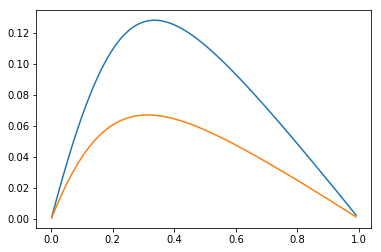

In [7]:
traj = []
for h in range(len(cond)):
    harmonies[1] = cond[h]
    xhist = np.zeros((2000, ndim))
    t = 0
    while t < 1999:
        if not_close(xhist[t], centers, 0.01):
            xhist[t+1,] = xhist[t,] + tau*step_dyn(xhist[t,], centers, harmonies, gamma)
            t += 1
        else:
            break
    traj.append(xhist[~np.all(xhist == 0, axis=1)])

for i in range(2):
    plt.plot(traj[i][:,0], traj[i][:,1])
plt.show()

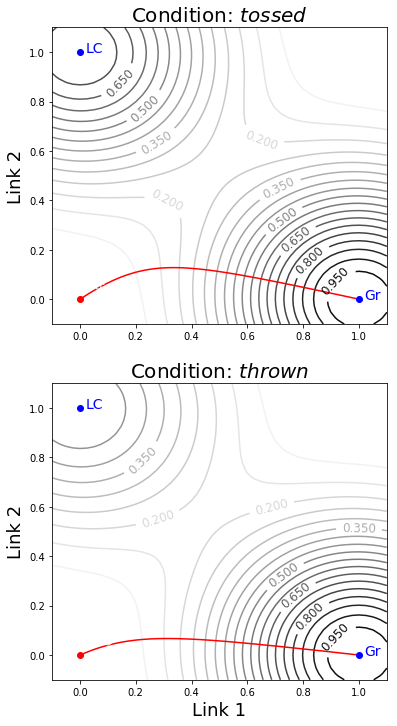

In [8]:
# Looking at the harmony landscape; only works for 2D
import numpy as np
import matplotlib.pyplot as plt
from itertools import product

conditions = ['tossed', 'thrown']
delta = 0.025
x1 = np.arange(-0.1, 1.1, delta)
x2 = np.arange(-0.1, 1.1, delta)
f, axarr = plt.subplots(2, sharex=True)
f.set_figheight(12)
f.set_figwidth(6)
for c in range(2):
    Z = np.zeros((len(x1), len(x2)))
    harmonies[1] = cond[c]
    for i, j in product(range(len(x1)), range(len(x2))):
        Z[i, j] = calc_harmony([x1[i], x2[j]], centers, harmonies, gamma)
    plt.subplot(2, 1, c+1)
    clines = plt.contour(x1, x2, Z.T, 20, cmap='binary', origin=None)  #RdGy_r, hot also good
    plt.clabel(clines, clines.levels[::3], inline=True, fontsize=12)
    plt.title('Condition: ${}$'.format(conditions[c]), fontsize=20)
    plt.ylabel('Link 2', fontsize=18)
    plt.plot(traj[c][:,0], traj[c][:,1], 'r-')
    plt.plot(0, 0, 'ro')
    plt.plot(1, 0, 'bo')
    plt.plot(0, 1, 'bo')
    plt.text(1.02, 0, 'Gr', fontsize=14, color='b')
    plt.text(0.02, 1, 'LC', fontsize=14, color='b')
plt.xlabel('Link 1', fontsize=18)
plt.show()

f.savefig('HarmonyContours.pdf', bbox_inches='tight')

In [290]:
# Making the toy harmony landscape for ICCM paper Fig. 2
from mpl_toolkits.mplot3d import Axes3D

gamma=0.2
cs = np.array([[0, 0,], [1, 0], [1, 1]])
hs = np.array([0.75, 0.5, 1.0])
delta = 0.01
x1 = np.arange(-1., 2, delta)
x2 = np.arange(-1., 2, delta)
XX, YY = np.meshgrid(x1, x1)
Z = np.zeros((len(x1), len(x2)))
for i, j in product(range(len(x1)), range(len(x2))):
        Z[i, j] = calc_harmony([x1[i], x2[j]], cs, hs, gamma)

In [291]:
# making a trajectory that climbs the harmony surface
xhist = np.zeros((1000, ndim))
xhist[0,:] = [-0.75, 0.5]
t = 0
while t < 150:
    #if not_close(xhist[t], centers, 0.01):
    xhist[t+1,] = xhist[t,] + tau*step_dyn(xhist[t,], cs, hs, gamma) + np.sqrt(2*D*tau)*np.random.normal(0, 1)
    t += 1
    #else:
        #break
traj = xhist[~np.all(xhist == 0, axis=1)]
currharm = np.zeros(traj.shape[0])
for i in range(len(currharm)):
    currharm[i] = calc_harmony(traj[i,:], cs, hs, gamma)

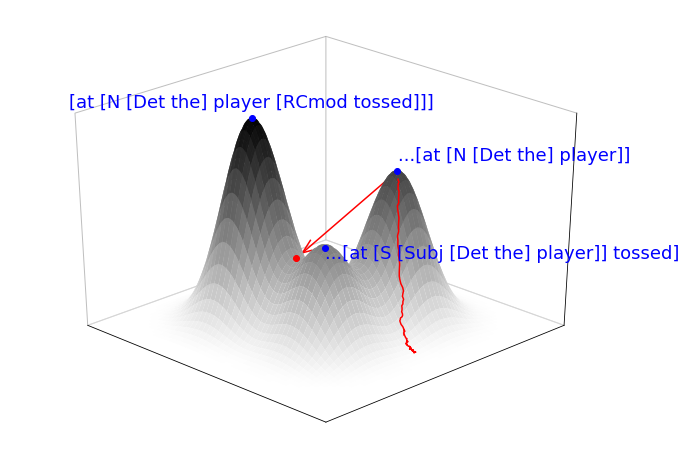

In [292]:
#%matplotlib notebook
#%matplotlib inline
from mpl_toolkits.mplot3d import axes3d
fig = plt.figure()
fig.set_figheight(8)
fig.set_figwidth(11)
ax.grid(False)
ax = fig.gca(projection='3d')
ax.plot_surface(XX, YY, Z, cmap='binary', alpha=0.95)#'coolwarm_r')
ax.plot3D(traj[:,0], traj[:,1], currharm, 'r-')
ax.plot([0.4], [1.], [0.4], 'ro')
ax.quiver(0, 0, 0.75, 0.4, 1.0, -0.35, edgecolor='r', length=0.94, arrow_length_ratio=0.1)

# making it look good
ax.view_init(elev=30., azim=135) #-55
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.xaxis.pane.set_edgecolor('gray')
ax.yaxis.pane.set_edgecolor('gray')
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.plot([0, 0, 1], [0, 1, 1], [0.75, 0.5, 1.], 'bo')
ax.text(0, 0, 0.8, '...[at [N [Det the] player]]', size=18, color='b', horizontalalignment='left')
ax.text(0, 1, 0.45, '...[at [S [Subj [Det the] player]] tossed]', size=18, color='b', horizontalalignment='left')
ax.text(1., 1, 1.05, '[at [N [Det the] player [RCmod tossed]]]', size=18, color='b', horizontalalignment='center')
plt.show()
fig.savefig('ToyHarmonySurface.pdf', bbox_inches='tight')